# Fuel assembly: 2B

## Import modules

In [11]:
import sys
import os

import openmc
import openmc.mgxs as mgxs

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

## Add location of OpenMC XS executable, setup ENDF xs path

In [1]:
import os

# Add path to OpenMC binary
# os.environ['PATH'] += r':/path/to/openmc/bin'

# Add location of OpenMC xs data
# %env OPENMC_CROSS_SECTIONS=/path/to/openmc/cross_sections.xml

## Start model

In [13]:
model=openmc.Model()

### Define Materials

In [14]:
uo2 = openmc.Material(name = 'uo2')

uo2.add_nuclide('U234', 6.11864E-06, 'ao')
uo2.add_nuclide('U235', 7.18132E-04, 'ao')
uo2.add_nuclide('U236', 3.29861E-06, 'ao')
uo2.add_nuclide('U238', 2.21546E-02, 'ao')
uo2.add_nuclide('O16', 4.57642E-02, 'ao')

uo2.set_density('g/cm3', 10.257 )

uo2.temperature = 600

In [15]:
zirconium = openmc.Material(name = "zirconium")

zirconium.add_nuclide('Zr90', 2.18865E-02, 'ao')
zirconium.add_nuclide('Zr91', 4.77292E-03, 'ao')
zirconium.add_nuclide('Zr92', 7.29551E-03, 'ao')
zirconium.add_nuclide('Zr94', 7.39335E-03, 'ao')
zirconium.add_nuclide('Zr96', 1.19110E-03, 'ao')
zirconium.add_nuclide('Sn112',4.68066E-06, 'ao')
zirconium.add_nuclide('Sn114', 3.18478E-06, 'ao')
zirconium.add_nuclide('Sn115', 1.64064E-06, 'ao')
zirconium.add_nuclide('Sn116', 7.01616E-05, 'ao')
zirconium.add_nuclide('Sn117', 3.70592E-05, 'ao')
zirconium.add_nuclide('Sn118', 1.16872E-04, 'ao')
zirconium.add_nuclide('Sn119', 4.14504E-05, 'ao')
zirconium.add_nuclide('Sn120', 1.57212E-04, 'ao')
zirconium.add_nuclide('Sn122', 2.23417E-05, 'ao')
zirconium.add_nuclide('Sn124', 2.79392E-05, 'ao')
zirconium.add_nuclide('Fe54', 8.68307E-06, 'ao')
zirconium.add_nuclide('Fe56', 1.36306E-04, 'ao')
zirconium.add_nuclide('Fe57', 3.14789E-06, 'ao')
zirconium.add_nuclide('Fe58', 4.18926E-07, 'ao')
zirconium.add_nuclide('Cr50', 3.30121E-06, 'ao')
zirconium.add_nuclide('Cr52', 6.36606E-05, 'ao')
zirconium.add_nuclide('Cr53', 7.21860E-06, 'ao')
zirconium.add_nuclide('Cr54', 1.79686E-06, 'ao')
zirconium.add_nuclide('Hf174', 3.54138E-09, 'ao')
zirconium.add_nuclide('Hf176', 1.16423E-07, 'ao')
zirconium.add_nuclide('Hf177', 4.11686E-07, 'ao')
zirconium.add_nuclide('Hf178', 6.03806E-07, 'ao')
zirconium.add_nuclide('Hf179', 3.01460E-07, 'ao')
zirconium.add_nuclide('Hf180', 7.76449E-07, 'ao')

zirconium.set_density('g/cm3',  6.56)

zirconium.temperature = 600

In [16]:
water = openmc.Material(name = "water")

water.add_nuclide('H1',4.96224E-02, 'ao')
water.add_nuclide('O16', 2.48112E-02, 'ao')
water.add_nuclide('B10', 1.07070E-05, 'ao')
water.add_nuclide('B11', 4.30971E-05, 'ao')

water.add_s_alpha_beta('c_H_in_H2O')

water.set_density('g/cm3', 0.661)

water.temperature = 600

In [17]:
helium = openmc.Material(name = "helium")

helium.add_nuclide('He4',1, 'ao')

helium.set_density('g/cm3', 0.178E-03 )

helium.temperature = 600

In [18]:
model.materials = openmc.Materials([uo2, zirconium, water,helium]) 

print(model.materials)

[Material
	ID             =	5
	Name           =	uo2
	Temperature    =	600
	Density        =	10.257 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U234           =	6.11864e-06  [ao]
	U235           =	0.000718132  [ao]
	U236           =	3.29861e-06  [ao]
	U238           =	0.0221546    [ao]
	O16            =	0.0457642    [ao]
, Material
	ID             =	6
	Name           =	zirconium
	Temperature    =	600
	Density        =	6.56 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.0218865    [ao]
	Zr91           =	0.00477292   [ao]
	Zr92           =	0.00729551   [ao]
	Zr94           =	0.00739335   [ao]
	Zr96           =	0.0011911    [ao]
	Sn112          =	4.68066e-06  [ao]
	Sn114          =	3.18478e-06  [ao]
	Sn115          =	1.64064e-06  [ao]
	Sn116          =	7.01616e-05  [ao]
	Sn117          =	3.70592e-05  [ao]
	Sn118          =	0.000116872  [ao]
	Sn119          =	4.14504e-05 

### Create fuel pin: fuel, clad, water (no gap)

In [19]:
def pincell(family):
    
    pitch = 1.26

    fuel_outer_radius = openmc.ZCylinder(r=0.4096)
    clad_inner_radius = openmc.ZCylinder(r=0.418)
    clad_outer_radius = openmc.ZCylinder(r=0.475)

    left   = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right  = openmc.XPlane( pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top    = openmc.YPlane( pitch/2, boundary_type='transmission')

    fuel_region  = -fuel_outer_radius
    gap_region   = +fuel_outer_radius & -clad_inner_radius
    clad_region  = +clad_inner_radius & -clad_outer_radius
    water_region = +left & -right & +bottom & -top & +clad_outer_radius

    fuel = openmc.Cell(name='fuel'+'_'+family)
    fuel.fill = uo2
    fuel.region = fuel_region
    
    gap = openmc.Cell(name='gap'+'_'+family)
    gap.region = gap_region
    gap.fill = helium     
    
    clad = openmc.Cell(name='clad'+'_'+family)
    clad.fill = zirconium
    clad.region = clad_region
    
    moderator = openmc.Cell(name='moderator'+'_'+family)
    moderator.fill = water
    moderator.region = water_region 
    
    u = openmc.Universe(name='u'+'_'+family, cells=(fuel, clad, moderator,gap))
    
    return(u,fuel,clad,moderator,gap)

### Create guide tube

In [20]:
def guide(family):
    
    pitch = 1.26

    clad_inner_radius = openmc.ZCylinder(r=0.561)
    clad_outer_radius = openmc.ZCylinder(r=0.602)
    
    left   = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right  = openmc.XPlane( pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top    = openmc.YPlane( pitch/2, boundary_type='transmission')       
    
    water_guide_region= -clad_inner_radius

    clad_region = +clad_inner_radius & -clad_outer_radius

    water_region = +left & -right & +bottom & -top & +clad_outer_radius
    
    water_guide = openmc.Cell(name='water'+'_'+family)
    water_guide.fill = water
    water_guide.region = water_guide_region
 
    clad = openmc.Cell(name='clad'+'_'+family)
    clad.fill = zirconium
    clad.region = clad_region

    moderator = openmc.Cell(name='moderator'+'_'+family)
    moderator.fill = water
    moderator.region = water_region 
    
    u = openmc.Universe(name='u_guide'+'_'+family, cells=(water_guide, clad, moderator))
    
    return(u,water_guide,water_guide,clad,moderator)

### Create instrumentation tube

In [21]:
def instru(family):
    pitch = 1.26

    clad_inner_radius = openmc.ZCylinder(r=0.559)
    clad_outer_radius = openmc.ZCylinder(r=0.605)
    
    left   = openmc.XPlane(-pitch/2, boundary_type='transmission')
    right  = openmc.XPlane( pitch/2, boundary_type='transmission')
    bottom = openmc.YPlane(-pitch/2, boundary_type='transmission')
    top    = openmc.YPlane( pitch/2, boundary_type='transmission')       
    
    water_guide_region = -clad_inner_radius

    clad_region = +clad_inner_radius & -clad_outer_radius
    
    water_region = +left & -right & +bottom & -top & +clad_outer_radius
    
    water_guide = openmc.Cell(name='water'+'_'+family)
    water_guide.fill = water
    water_guide.region = water_guide_region
    
    clad = openmc.Cell(name='clad'+'_'+family)
    clad.fill = zirconium
    clad.region = clad_region
    
    moderator = openmc.Cell(name='moderator'+'_'+family)
    moderator.fill = water
    moderator.region = water_region 
    
    u = openmc.Universe(name='u_guide'+'_'+family, cells=(water_guide, clad, moderator))
    
    return(u,water_guide,water_guide,clad,moderator)

### Mapping onto the lattice

In [22]:
GT=[(5,2),(8,2),(3,3),(2,5),(5,5),(8,5),(2,8),(5,8)]
IT=[(8,8)]

GT_left=[]
GT_full=[]
for X in GT:
    GT_left.append((X[0],X[1]))
    GT_left.append((X[0],16-X[1]))
for X in GT_left:
    GT_full.append((X[0],X[1]))
    GT_full.append((16-X[0],X[1]))    
GT_full = list(set(GT_full))
# print(np.array(GT_full)+(1,1))

### Generate cells

In [23]:
pincell_1_family = pincell('pincell')
guide_1_family   = guide('guide')
instru_1_family  = instru('instru')

### Generate assembly

In [24]:
assembly = openmc.RectLattice()
pitch = 1.26

dr = 0.04 # cm of water that is outside assembly

size = 17 #size of the assembly 
assembly.pitch = (pitch,pitch)

assembly.lower_left = (-size*pitch/2, -size*pitch/2)


A = np.empty((size, size), dtype=openmc.universe.Universe)

for ix in range(size):
    for iy in range(size):
        if (ix,iy) in GT_full : 
            A[ix][iy]=guide_1_family[0]
        elif (ix,iy) in IT :
            A[ix][iy]=instru_1_family[0]
        else:
            A[ix][iy]=pincell_1_family[0]    
        
assembly.universes = A

moderator_outside = openmc.Cell(name='water_outside')
moderator_outside.fill = water

all_water = openmc.Universe()
all_water.add_cell(moderator_outside)
assembly.outer=all_water

height = 385.1
# 1/4 assembly
min_x = openmc.XPlane(x0=-(size/2*pitch+dr), boundary_type='reflective')
max_x = openmc.XPlane(x0=0, boundary_type='reflective')
min_y = openmc.YPlane(y0=0, boundary_type='reflective')
max_y = openmc.YPlane(y0=+(size/2*pitch+dr), boundary_type='reflective')
min_z = openmc.ZPlane(z0=-height/2, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+height/2, boundary_type='reflective')

root_cell = openmc.Cell(name='root cell', fill=assembly)
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

model.geometry.root_universe = openmc.Universe(name='root universe')
model.geometry.root_universe.add_cell(root_cell)

### Plot

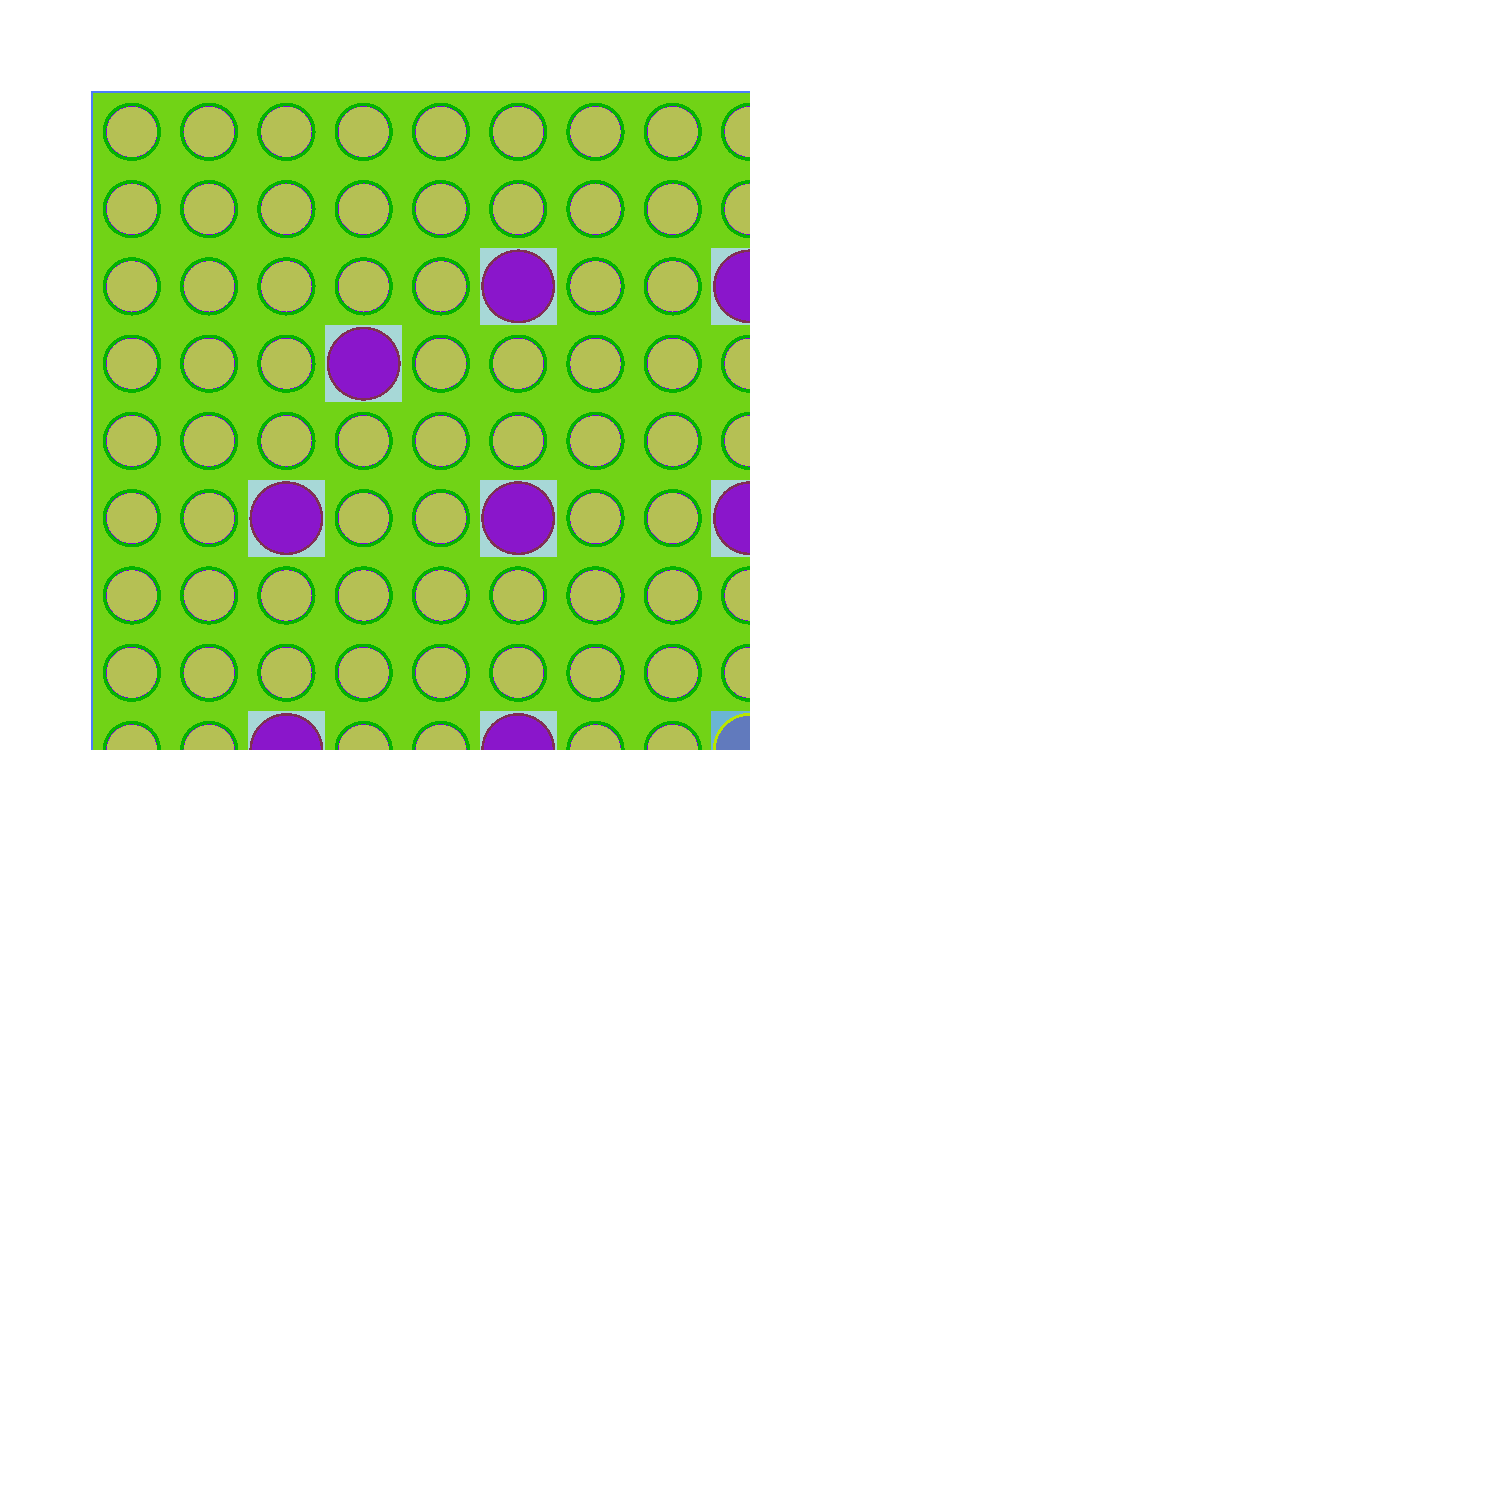

In [25]:
# export needed for plotting
model.materials.export_to_xml()
model.geometry.export_to_xml()

plot = openmc.Plot()
plot.filename = '2B'
plot.from_geometry(model.geometry)
plot.pixels = (1500, 1500)

pitch_assembly = size*pitch + dr 

plot.width = (pitch_assembly+3, pitch_assembly+3)

plot.origin = (0., 0., 0.)
plot.color_by = 'cell'

model.plots = openmc.Plots([plot])
plot.to_ipython_image(openmc_exec='openmc', cwd='./')

###  Settings

In [26]:
settings = openmc.Settings()

bounds = [-pitch_assembly/2, 0, -height/2, 0, +pitch_assembly/2, height/2]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)

source = openmc.IndependentSource(space=uniform_dist)

settings.source = source

settings.batches = 50
settings.inactive = 20
settings.particles = 50000
settings.keff_trigger = {'type':'std_dev','threshold':0.00100}
settings.trigger_active = True
settings.trigger_max_batches = 50000
settings.output = {'tallies':True}

settings.temperature['method'] = 'interpolation'

model.settings = settings

### Tallies

In [27]:
tallies = openmc.Tallies()
model.tallies = tallies

### Define and choose energy group

In [28]:
egroup_name = 'SHEM-361'
egroup = openmc.mgxs.GROUP_STRUCTURES[egroup_name]

### Create MGXS tallies for mgxs directory

In [29]:
pn = 7
    
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(egroup)

mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.mgxs_types = ['total', 'absorption', 'nu-fission', 'fission' ,'chi', \
                       'consistent nu-scatter matrix', 'multiplicity matrix','kappa-fission']

mgxs_lib.legendre_order = pn
if pn == 0:
    mgxs_lib.correction = None

mgxs_lib.by_nuclide = False
mgxs_lib.domain_type = 'cell'
mgxs_lib.domains = model.geometry.get_all_material_cells().values()
# print(mgxs_lib.domains)

all_cell_order=[]
for cell in (mgxs_lib.domains):
    all_cell_order.append(cell.name)
print(all_cell_order)

mgxs_lib.build_library()
    
mgxs_lib.build_library()
mgxs_lib.check_library_for_openmc_mgxs()

mgxs_lib.add_to_tallies_file(tallies, merge=True)

['fuel_pincell', 'clad_pincell', 'moderator_pincell', 'gap_pincell', 'water_guide', 'clad_guide', 'moderator_guide', 'water_instru', 'clad_instru', 'moderator_instru', 'water_outside']


/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 7 is greater than zero
  warn(msg, RuntimeWarning)


### Create power tally

In [30]:
## model.export_to_model_xml('model_iso.xml')

### Run OpenMC model

In [31]:
sp_file = model.run()

/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=400.
  warn(msg, IDWarning)
/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/Users/jean.ragusa/anaconda3/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=10.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [32]:
# trick to make several runs work with jupyter
try:
    sp 
    print('sp found')
    sp.close()
except NameError:
    print('sp NOT found')

sp NOT found


In [34]:
sp = openmc.StatePoint(sp_file, autolink=False)
su = openmc.Summary('summary.h5')
sp.link_with_summary(su)

In [35]:
mgxs_lib.load_from_statepoint(sp)
    
pb_name = '2B'
mgxs_lib.create_mg_library(xs_type='macro', xsdata_names=all_cell_order).export_to_hdf5\
('mgxs_' + pb_name + '.h5')